<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Models</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. Datasets](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
* [2. Preprocessing & Feature Engineering](#2)
  * [2.1 Target variable distribution](#2.1)
  * [2.2 Missing values](#2.2)
  * [2.3 Exploratory Analysis](#2.3)
  * [2.4 Features Importance](#2.4)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost as cat
from catboost import CatBoostRegressor
from sklearn import metrics

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.9.6


In [3]:
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

seaborn   : 0.11.1
matplotlib: 3.4.2
catboost  : 0.26.1
sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
lightgbm  : 3.2.1
pandas    : 1.3.0
numpy     : 1.21.1
sklearn   : 0.24.2
xgboost   : 1.4.0



## Splitting dataset in train and test

In [4]:
hourly_data = pd.read_csv('../data/processed/hourly_data.csv')
hourly_data.shape

(6966, 17)

In [5]:
df = hourly_data.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category',
                'rental_hour': 'category',
                'season': 'category',
                'peak': 'category',
                'timesofday': 'category'})
predictors = ['temp','wdsp','rhum','rain_type','holiday','season','dayofweek','working_day','peak','timesofday']


X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((4876, 10), (2090, 10))

## Split columns in categorical and numerical

In [6]:
num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors]
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]
# nu
ord_var = ['rain_type']
num_vars, cat_vars, ord_var

(['temp', 'rhum', 'wdsp'],
 ['holiday', 'dayofweek', 'working_day', 'season', 'peak', 'timesofday'],
 ['rain_type'])

## Preprocessing Pipelines

In [7]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())
    ('scaler', MinMaxScaler())
])

ord_pipe = Pipeline([
    ('ordinal_enconder', OrdinalEncoder(dtype=np.int64, categories=[['no rain', 
                                                                     'drizzle', 
                                                                     'light rain', 
                                                                     'moderate rain', 
                                                                     'heavy rain']]))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('ordinal_enconder', ord_pipe, ord_var),
    ('num', num_pipe, num_vars)
], remainder='passthrough')

## Feature Importance

In [8]:
# LightGBM model
params_lightgbm = {'n_estimators': 1500, 
                   'boosting_type': 'dart', 
                   'max_depth': 5, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7, 
                   'importance_type': 'gain'
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['holiday', 'dayofweek',
                                                   'working_day', 'season',
                                                   'peak', 'timesofday']),
                                                 ('ordinal_enconder',
                                                  Pipeline(steps=[('ordinal_enconder',
                                                                   OrdinalEncoder(categories=[['no '
                                                                                   

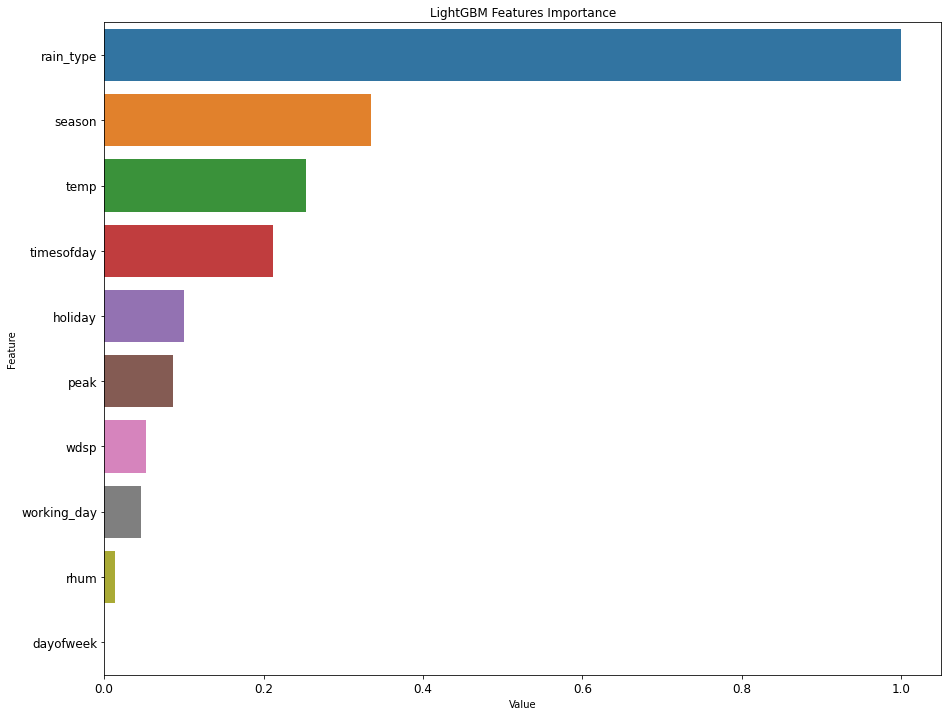

In [9]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [16]:
def print_evalmetrics(actual, predicted):
    print('RMSE:', metrics.mean_squared_error(actual, predicted, squared=False))
    print('MAE:', metrics.mean_absolute_error(actual, predicted))
    

## Random Forest Regressor

In [17]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5, 
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

RMSE: 2.889013663037282
MAE: 2.1950821461313854


## Support Vector Regression

In [18]:
from sklearn.svm import SVR

# Fit a pipeline with transformers and an estimator to the training data
pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='poly',gamma='scale',C=100))
])
pipe_svr.fit(X_train, y_train)
y_train_pred = pipe_svr.predict(X_train)
y_test_pred = pipe_svr.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

RMSE: 2.9852805928918777
MAE: 2.209594506087855


In [19]:
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# define the model cross-validation configuration
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(pipe_svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert MAE scores to positive values
scores = absolute(scores)
# summarize the model performance
print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
y_test_pred = pipe_svr.predict(X_test)
print_evalmetrics(y_test, y_test_pred)

MAE: 2.199 (0.090)
RMSE: 2.9852805928918777
MAE: 2.209594506087855


In [20]:
predicted_values = pd.DataFrame()
predicted_values['real'] = y_test
predicted_values['predicted'] = y_test_pred

predicted_values

,real,predicted
3487,9,8.027402
2977,2,2.063730
5003,3,6.480979
37,3,3.811070
4305,12,6.252290
...,...,...
978,19,9.411525
6175,8,4.596759
4938,1,2.505832
2521,1,1.823701


## GradientBoost

In [21]:
# GBM model
params_gbm = {'n_estimators': 150, 
              'max_depth': 5, 
              'random_state': 0, 
              'min_samples_leaf' : 10, 
              'learning_rate': 0.01, 
              'subsample': 0.7, 
              'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

RMSE: 2.9230160492583934
MAE: 2.2422790246359607


## LightGBM

In [22]:
# LightGBM model
params_lightgbm = {'n_estimators': 1000, 
                   'max_depth': 15, 
                   'random_state': 0, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7,
                   'num_leaves': 30,
                   'metric': 'rmse',
                   'n_jobs': 2
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print_evalmetrics(y_test, y_test_pred)

RMSE: 2.8752286870625605
MAE: 2.1750779265799114


In [23]:
%%time

cv = KFold(n_splits=3, shuffle=True, random_state=2022)

for n_fold, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    print('#'*40, f'Fold {n_fold+1} out of {cv.n_splits}', '#'*40)
    
    # X_train, y_train = X[train_index], y[train_index] # Train data
    # X_val, y_val = X[test_index], y[test_index] # Valid data
    
    # pipe_gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
    #           verbose=250, early_stopping_rounds=50)
    
    # preds_lgb[test_index] += pipe_gbm.predict(X_val, raw_score=False)

######################################## Fold 1 out of 3 ########################################
######################################## Fold 2 out of 3 ########################################
######################################## Fold 3 out of 3 ########################################
CPU times: user 4.72 ms, sys: 1.97 ms, total: 6.69 ms
Wall time: 2.87 ms


## Catboost

In [24]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=1, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('\n')
print_evalmetrics(y_test, y_test_pred)

Learning rate set to 0.297767
0:	learn: 3.1840655	total: 55.6ms	remaining: 5.5s
1:	learn: 3.0386218	total: 57.8ms	remaining: 2.83s
2:	learn: 2.9451812	total: 59.6ms	remaining: 1.93s
3:	learn: 2.8912967	total: 61.1ms	remaining: 1.47s
4:	learn: 2.8517514	total: 62.8ms	remaining: 1.19s
5:	learn: 2.8298851	total: 65.1ms	remaining: 1.02s
6:	learn: 2.8142532	total: 66.6ms	remaining: 885ms
7:	learn: 2.8035112	total: 67.9ms	remaining: 780ms
8:	learn: 2.7893777	total: 69.8ms	remaining: 706ms
9:	learn: 2.7793202	total: 71.8ms	remaining: 646ms
10:	learn: 2.7673413	total: 73.6ms	remaining: 595ms
11:	learn: 2.7612687	total: 75.4ms	remaining: 553ms
12:	learn: 2.7514520	total: 76.8ms	remaining: 514ms
13:	learn: 2.7445974	total: 78.2ms	remaining: 480ms
14:	learn: 2.7344935	total: 79.7ms	remaining: 452ms
15:	learn: 2.7280243	total: 81ms	remaining: 426ms
16:	learn: 2.7245192	total: 82.3ms	remaining: 402ms
17:	learn: 2.7140733	total: 83.6ms	remaining: 381ms
18:	learn: 2.7064118	total: 85.2ms	remaining: 3

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini